In [1]:
import pyemma
import tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm.auto import tqdm

In [2]:
import sys

In [3]:
sys.path.append('/Users/thempel/fustorage/projects/vha_auschwitz_report/')

In [4]:
import constants

In [5]:
from markov_modelling import markov_utils as mu

In [6]:
# Load the input data
input_directory = '../' + constants.output_data_segment_keyword_matrix

# Read the segment index term matrix
data = np.load(input_directory + constants.output_segment_keyword_matrix_data_file.replace('.txt', '.npy'), 
              allow_pickle=True)
# Read the column index (index terms) of the matrix above
features_df = pd.read_csv(input_directory + 
                      constants.output_segment_keyword_matrix_feature_index)

# Create the row index  of the matrix above
segment_df = pd.read_csv(input_directory + 
                     constants.output_segment_keyword_matrix_document_index)

int_codes = segment_df['IntCode'].to_list()


# Set the output directory
output_directory_temp = constants.output_data_markov_modelling

# Read the metadata partitions
with open(input_directory + "metadata_partitions.json") as read_file:
    metadata_partitions = json.load(read_file)

In [7]:
def estimate_pi_error(dtrajs, orig_msm, ntrails=10, conf_interval=0.68, return_samples=False):
    """
    Estimate boostrap error for stationary probability
    
    :param dtrajs: list of np.array, discrete trajectories
    :param orig_msm: pyemma.msm.MarkovModel
    Only used for reference of lag time and to incorporate ML 
    stationary distribution to data frame
    :param ntrails: int, the number of bootstrap samples to draw. 
    :param conf_interval: float 0 < conf_interval < 1
    
    :return:
    pandas.DataFrame instance containing ML MSM pi and bootstrap error
    """
    from pyemma.util.statistics import confidence_interval
    
    pi_samples = np.zeros((ntrails, orig_msm.nstates))

    for trial in tqdm(range(ntrails)):
        try:
            bs_sample = np.random.choice(len(dtrajs), 
                 size=len(dtrajs), 
                replace=True)
            dtraj_sample = list(np.array(dtrajs)[bs_sample])

            msm = pyemma.msm.estimate_markov_model(dtraj_sample, 
                                                    lag=orig_msm.lag)

            pi_samples[trial, msm.active_set] = msm.pi
        except Exception as e: 
            print(e)
            
    if return_samples:
        return pi_samples
    
    
    std = pi_samples.std(axis=0)
    lower_confidence, upper_confidence = confidence_interval(pi_samples, conf_interval)
    
    probabilities = pd.DataFrame(np.array([orig_msm.active_set, 
                                           orig_msm.pi, 
                                           std, 
                                           lower_confidence, 
                                           upper_confidence]).T,
                    columns=['State', 'StatDist', 'Std', 'LowerConf', 'UpperConf'], )
    
    # type cast to int
    probabilities['State'] = probabilities['State'].astype(int)
    
    
    return probabilities

In [8]:
samples = {}
msms = {}
for key in ['complete_m', 'complete_w']:
    indices = metadata_partitions[key]


    input_data_set = np.take(data,indices)
    # Make sure that interviews with only one segment are not included
    for i in range(0,input_data_set.shape[0]):
        assert (input_data_set[i].shape[0]>1)


    # Estimate fuzzy trajectories
    #empyt = [element[0] for element in input_data_set if element[0].sum()==0]
    trajs = mu.estimate_fuzzy_trajectories(input_data_set)

    # Estimate the Markov model from the trajectories
    msm = mu.estimate_markov_model_from_trajectories(trajs)
    
    error_est = estimate_pi_error(trajs, msm, return_samples=True, ntrails=50)
    
    samples[key] = error_est
    msms[key] = msm

19-12-20 11:13:19 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[1] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


19-12-20 11:13:29 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[2] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:13:38 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[3] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:13:47 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:13:57 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:14:07 pyemma.msm.estimat

19-12-20 11:18:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[36] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:19:01 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[37] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:19:10 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[38] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:19:20 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[39] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:19:29 pyemma.msm.est

19-12-20 11:21:45 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[52] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:22:06 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[53] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:22:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[54] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:22:49 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[55] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:23:11 pyemma.msm.est

19-12-20 11:33:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[86] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:34:14 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[87] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:34:35 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[88] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:34:57 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[89] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
19-12-20 11:35:19 pyemma.msm.est

In [9]:
from pyemma.util.statistics import confidence_interval

Text(0.5,1,'food sharing')

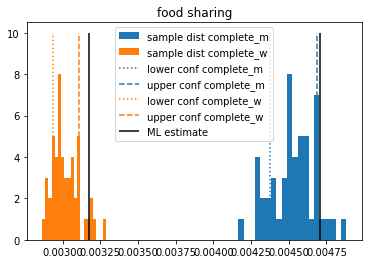

In [65]:
food_sharing_index = 34
for n, k in enumerate(['complete_m', 'complete_w']):
    state_samples = samples[k][:, food_sharing_index]
    plt.hist(state_samples, bins=20, label=f'sample dist {k}', color=f'C{n}')
    
    lower_confidence, upper_confidence = confidence_interval(state_samples, 0.68)
    plt.vlines(lower_confidence, 0, 10,  color=f'C{n}', linestyle=':', label=f'lower conf {k}')
    plt.vlines(upper_confidence, 0, 10,  color=f'C{n}', linestyle='--', label=f'upper conf {k}')
    plt.vlines(msms[k].pi[food_sharing_index], 0, 10, color='k', label='ML estimate' if n==1 else None)
    
plt.legend()
plt.title('food sharing')

In [ ]:
### PLEASE IGNORE BELOW!

In [ ]:
msm.nstates

In [ ]:
msms = {}
bmsms = {}
for l in labels:
    msms[l] = pyemma.load(f'../data/output/markov_modelling/{l}/pyemma_model', 
                 model_name='simple')
    bmsms[l] = pyemma.load(f'../data/output/markov_modelling/{l}/pyemma_model_bayes', 
                 model_name='simple')

In [ ]:
ntrails = 10
msmlag=2

In [ ]:
bootstrapping_trajs = {}
bootstrapping_asshmms = {}
bootstrapping_samples = {}
itses = {}
pi_samples = {}

for partition in tqdm(metadata_partitions):
    print(partition)
    
    indices = metadata_partitions[key]
    input_data_set = np.take(data,indices)


    # Estimate fuzzy trajectories
    dtrajs = mu.estimate_fuzzy_trajectories(input_data_set)
    
    bootstrapping_samples[partition] = []
    itses[partition] = []
    pi_samples[partition] = np.zeros((ntrails, np.concatenate(dtrajs).max() + 1))
    
    

    for trial in tqdm(range(ntrails)):
        ts = -1
        try:
            # DTRAJS = ....
            
            # attention, lagging outside bc of stride
            bs_sample = np.random.choice(len(dtrajs), 
                 size=len(dtrajs), 
                replace=True)
            dtraj_sample = list(np.array(dtrajs)[bs_sample])

            msm = pyemma.msm.estimate_markov_model(dtraj_sample, 
                                                    lag=msmlag)
            
            itses[partition].append(msm.timescales().max())
            #ratematrix = get_ratematrix(association_binding_model, association_binding_model.lag)
            pi_samples[partition][trial, :] = msm.pi
        except Exception as e: # was exception
            print(e)
            
    break

In [ ]:
msm.active_set.shape

In [ ]:
msm.pi.shape

In [ ]:
lower_confidence.shape

In [ ]:
std.shape

In [ ]:
upper_confidence.shape

In [ ]:
probabilities = pd.DataFrame(np.array([msm.active_set, msm.pi, std, lower_confidence, upper_confidence]).T,
                    columns=['State', 'StatDist', 'Std', 'LowerConf', 'UpperConf'], )
probabilities['State'] = probabilities['State'].astype(int)
probabilities

In [ ]:
probabilities.to_csv('')

In [ ]:

std = pi_samples['complete'].std(axis=0)
lower_confidence, upper_confidence = confidence_interval(pi_samples['complete'])
plt.plot(msm.pi)
plt.plot(lower_confidence)
plt.plot(upper_confidence)
plt.plot(msm.pi + std)
plt.plot(msm.pi - std)

In [ ]:
pi_samples['complete']

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))
for state in range(3):
    for _n, d in enumerate(drugs):
        #print(pi_samples[d][:, state].mean())
        ax[0, state].hist(pi_samples[d][:, state], color=f'C{_n}', alpha=.5, 
                       label=d if state == 0 else None)
        ax[0, state].vlines(association_binding_models[d].pi[state], 0, 
                    ax[0, state].get_ylim()[1], 
                    color=f'C{_n}', linestyle=':')
fig.legend()